<a href="https://colab.research.google.com/github/artemtu/projects-by-artemtu/blob/main/sbornyj_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование поведения пользователей мобильного приложения по заказу продуктов питания

**Описание данных** 
logs_exp.csv

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

**Задачи проекта:**


### [Подготовка данных](#start)

- проверить названия столбцов и заменить их (при необходимости)
- проверить пропуски и типы данных
- добавить столбец даты и времени, а также отдельный столбец дат

### [Изучение и проверка данных](#discover_data)

- сколько событий в логе?
- сколько пользователей в логе?
- сколько в среднем событий приходится на пользователя?
- данными за какой период мы располагаем? Найти максимальную и минимальную дату. Построить гистограмму по дате и времени. Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определить, с какого момента данные полные и отбросить более старые. Данными за какой период времени мы располагаем на самом деле?
- много ли событий и пользователей мы потеряли, отбросив старые данные?
- проверить, что у нас есть пользователи из всех трёх экспериментальных групп

### [Изучение воронки событий](#pipeline)

- посмотреть какие события есть в логах, как часто они встречаются. Отсортировать события по частоте
- посчитать сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие
- предположить в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки
- по воронке событий посчитать какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитать отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B
- на каком шаге теряете больше всего пользователей?
- какая доля пользователей доходит от первого события до оплаты?

### [Изучение результатов эксперимента](#a/b)

- сколько пользователей в каждой экспериментальной группе?
- есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверить, находят ли статистические критерии разницу между выборками 246 и 247.
- выбрать самое популярное событие. Посчитать число пользователей, совершивших это событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Проделать то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- аналогично поступить с группой с изменённым шрифтом. Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитать сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? 

# Открытие и подготовка данных
<a id="start"></a>


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import factorial
import math
from scipy import stats as st
from IPython.display import display_html
from itertools import chain,cycle
import seaborn as sns
import datetime as dt
import scipy.stats as stats
import datetime
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats as st
import numpy as np
import math as mth
import warnings

In [2]:
  warnings.filterwarnings("ignore")

In [80]:
logs = pd.read_csv('/content/drive/MyDrive/Pandas_files/resume/logs_exp.csv', sep='\t') # read csv

In [81]:
logs.head(3) #first view data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


In [82]:
logs['EventTimestamp'] = pd.to_datetime(logs['EventTimestamp'], unit='s') #приводим к формату дата

In [83]:
logs

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [84]:
logs.set_axis(['event', 'user_id', 'datetime', 'expld'], axis=1, inplace=True) #переименовываем столбцы

In [85]:
logs.head(3)

,event,user_id,datetime,expld
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248


In [86]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     244126 non-null  object        
 1   user_id   244126 non-null  int64         
 2   datetime  244126 non-null  datetime64[ns]
 3   expld     244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [87]:
logs.duplicated().sum() #получаем кол-во дубликатов

413

In [88]:
logs[logs.duplicated(keep=False)].head(10) # получаем дубликаты

,event,user_id,datetime,expld
452,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248
2348,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248
3572,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248
4075,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247
4801,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248


In [89]:
logs.drop_duplicates(inplace=True) #удаляем дубликаты

In [90]:
logs.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     243713 non-null  object        
 1   user_id   243713 non-null  int64         
 2   datetime  243713 non-null  datetime64[ns]
 3   expld     243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


In [91]:
logs['date'] = logs['datetime'].dt.date #добавляем столбец с датой

In [92]:
logs['date'] = pd.to_datetime(logs['date']) # приводим к формату "дата"

In [93]:
logs.info() #проверяем внесенные изменения

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     243713 non-null  object        
 1   user_id   243713 non-null  int64         
 2   datetime  243713 non-null  datetime64[ns]
 3   expld     243713 non-null  int64         
 4   date      243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


In [94]:
logs.head(5)

,event,user_id,datetime,expld,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [95]:
logs['event'].unique() #получаем уникальные шаги воронки

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [96]:
logs.groupby('user_id')['expld'].nunique().sort_values(ascending = False) # проверяем нет ли одного и того же пользователя в нескольких группах

user_id
9222603179720523844    1
3184294769293286652    1
3167390091686880227    1
3167974726645136146    1
3170212200647575044    1
                      ..
6213626876710715478    1
6215162890135937308    1
6215559225876063378    1
6216080220799726690    1
6888746892508752       1
Name: expld, Length: 7551, dtype: int64

**Вывод**

подготовили данные, проверили и удалили дубликаты, осуществили проверку на вхождение одного пользователеля во множество групп, переименовали столбцы и привели данные к нужным типам. Всё готово для проверки

# Изучение и проверка данных
<a id="discover_data"></a>

In [97]:
len(logs) #количество записей

243713

In [98]:
logs['user_id'].nunique() #кол-во уникальных пользователей

7551

In [99]:
243713 / 7551 #соотношение событий к пользователям

32.27559263673685

In [23]:
logs['date'].min()

Timestamp('2019-07-25 00:00:00')

In [24]:
logs['date'].max()

Timestamp('2019-08-07 00:00:00')

(0.0, 40000.0)

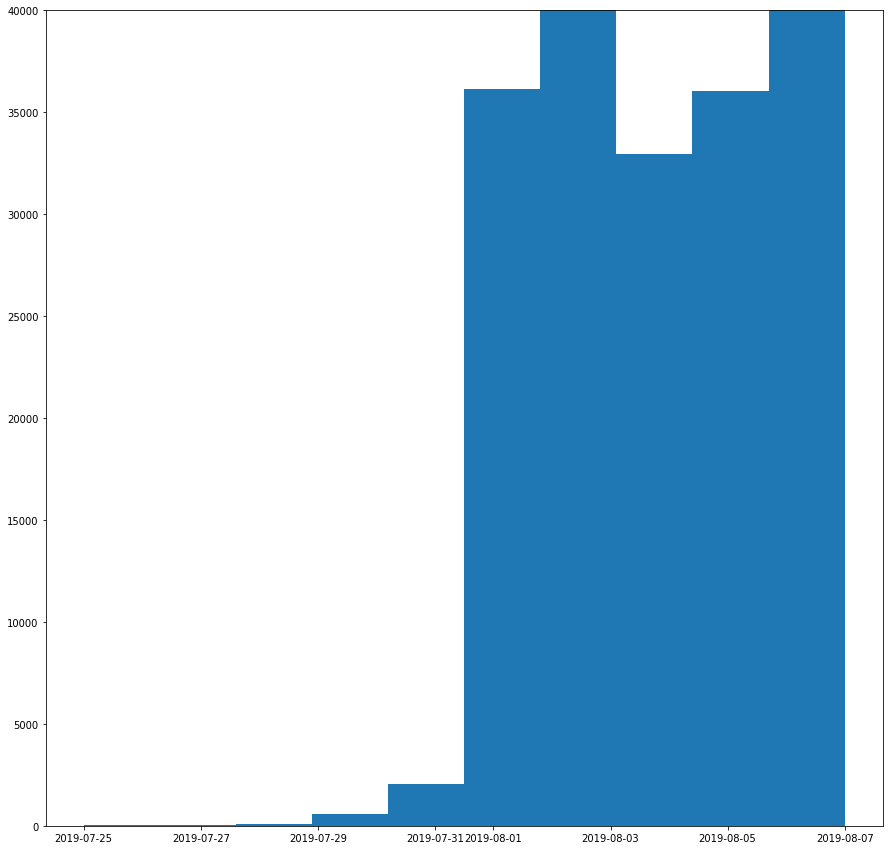

In [100]:
plt.figure(figsize=(15, 15))
plt.hist(logs['date'])
plt.ylim((0, 40000))

#график, который помогает найти данные к удалению

In [101]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     243713 non-null  object        
 1   user_id   243713 non-null  int64         
 2   datetime  243713 non-null  datetime64[ns]
 3   expld     243713 non-null  int64         
 4   date      243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


In [102]:
logs = logs.query('(date >= "2019-08-01")') #отсекаем данные по опр.дате

In [103]:
logs

,event,user_id,datetime,expld,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


(0.0, 40000.0)

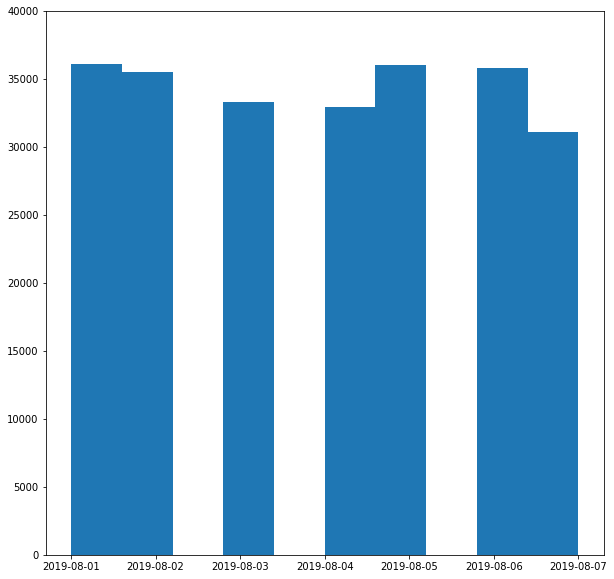

In [104]:
plt.figure(figsize=(10, 10))
plt.hist(logs['date'])
plt.ylim((0, 40000))

In [105]:
logs['date'].min()

Timestamp('2019-08-01 00:00:00')

In [106]:
logs['date'].max()

Timestamp('2019-08-07 00:00:00')

In [107]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     240887 non-null  object        
 1   user_id   240887 non-null  int64         
 2   datetime  240887 non-null  datetime64[ns]
 3   expld     240887 non-null  int64         
 4   date      240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [108]:
logs['user_id'].nunique()

7534

In [109]:
243713 - 204746 #количество потерянных данных

38967

In [110]:
7551 - 7286 #количество потерянных пользователей

265

<div class="alert alert-block alert-warning">
<b>Комментарий от ревьюера</b>

Тут лучше работать с переменными. Если не знаешь о чем речь,сложно будет понять что это за цифры. :)  
</div>

In [111]:
logs.groupby('expld')['user_id'].agg(['nunique']) #распределение пользователей по группам

,nunique
expld,
246,2484
247,2513
248,2537


**Вывод**
1. После чистки от дубликатов событий в логе осталось 243713, количество пользователей:7551
2. В среднем на одного пользователя приходится 32 события
3. Более полные данные с 2019-08-01
4. Отбросив старые данные мы потеряли 38967 событий и 265 уникальных пользователей

# Изучение воронки событий
<a id="pipeline"></a>

In [112]:
logs.head(3)

,event,user_id,datetime,expld,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01


In [113]:
logs.pivot_table(index='event', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False) # сводная таблица, в которой получаем кол-во событий по шагам

,user_id
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Main Screen Appear - главный экран

Offers Screen Appear - экран предложения

Cart Screen Appear - экран корзины

Payment Screen Successful - успешная оплата

Tutorial - инструкция

In [114]:
user_activity = logs.groupby('event').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index() #количество пользователей в каждом событии

In [115]:
user_activity

,event,user_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [116]:
user_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   event    5 non-null      object
 1   user_id  5 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [117]:
fig = go.Figure(data=[go.Funnel(y=user_activity.event, x=user_activity.user_id, textposition='inside', textinfo='value + percent previous', marker_color='#12aadc')])
# воронка продаж

In [118]:
fig

**Вывод**
1. Самое частое событие - просмотр главного экрана, далее просмотр предложений, корзина и оплата. 
2. 7419 пользователей перешли на главный экран, просмотрели предложения уже 4593 пользователя (именно на этом этапе мы больше всего теряем пользователей), в корзину перешли 3734 пользователя, а провели оплату 3539! Также у нас есть событие "инструкция". Кажется, оно не совсем логично в воронке или вовсе не требуется пользователям. В некоторых современных приложениях "инструкция" открывается после первого открытия приложения, а далее можно пройти обучение, а можно просто пропустить. В нашем исследовании я принял решение не учитывать этот шаг при подсчетах результатов эксперимента
3. Благодаря воронке, нам удалось выяснить , что при переходе на второй шаг мы теряем 38% пользователей, а далее конверсия растёт. Предлоежние - корзина = 81% и корзина - оплата = 94,8%. Общая конверсия (переход из меню в покупку = 17,6%), есть над чем поработать.

# Изучение результатов эксперимента
<a id="a/b"></a>

In [119]:
logs['expld'].unique()

array([246, 247, 248])

In [120]:
users_246 = logs.query('(expld == 246)')

In [121]:
users_246

,event,user_id,datetime,expld,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2834,OffersScreenAppear,3737462046622621720,2019-08-01 00:10:26,246,2019-08-01
...,...,...,...,...,...
244120,MainScreenAppear,5746969938801999050,2019-08-07 21:12:11,246,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [122]:
users_246.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79302 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   event     79302 non-null  object        
 1   user_id   79302 non-null  int64         
 2   datetime  79302 non-null  datetime64[ns]
 3   expld     79302 non-null  int64         
 4   date      79302 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 3.6+ MB


In [123]:
users_247 = logs.query('(expld == 247)')
#users_247 = users_247['user_id'].nunique()

In [124]:
users_247

,event,user_id,datetime,expld,date
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2833,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01
2838,MainScreenAppear,4899590676214355127,2019-08-01 00:11:28,247,2019-08-01
2839,OffersScreenAppear,4899590676214355127,2019-08-01 00:11:30,247,2019-08-01
2843,OffersScreenAppear,4899590676214355127,2019-08-01 00:12:36,247,2019-08-01
...,...,...,...,...,...
244088,MainScreenAppear,2300292234025330845,2019-08-07 21:05:37,247,2019-08-07
244089,OffersScreenAppear,2300292234025330845,2019-08-07 21:05:43,247,2019-08-07
244090,OffersScreenAppear,2300292234025330845,2019-08-07 21:05:54,247,2019-08-07
244091,MainScreenAppear,2300292234025330845,2019-08-07 21:05:57,247,2019-08-07


In [125]:
users_248 = logs.query('(expld == 248)')
#users_248 = users_248['user_id'].nunique()

In [126]:
users_248

,event,user_id,datetime,expld,date
2844,MainScreenAppear,4613461174774205834,2019-08-01 00:14:31,248,2019-08-01
2845,MainScreenAppear,4613461174774205834,2019-08-01 00:14:34,248,2019-08-01
2846,CartScreenAppear,4613461174774205834,2019-08-01 00:14:34,248,2019-08-01
2847,PaymentScreenSuccessful,4613461174774205834,2019-08-01 00:14:43,248,2019-08-01
2848,OffersScreenAppear,4613461174774205834,2019-08-01 00:14:51,248,2019-08-01
...,...,...,...,...,...
244082,MainScreenAppear,8249271441488197538,2019-08-07 21:03:33,248,2019-08-07
244084,OffersScreenAppear,8249271441488197538,2019-08-07 21:03:43,248,2019-08-07
244109,MainScreenAppear,5317814261427487562,2019-08-07 21:09:22,248,2019-08-07
244110,OffersScreenAppear,5317814261427487562,2019-08-07 21:09:27,248,2019-08-07


In [127]:
print('в группе 246 всего пользователей:',users_246['user_id'].nunique() )  
   
print('в группе 247 всего пользователей:',users_247['user_id'].nunique())
       
print('в группе 248 всего пользователей:',users_248['user_id'].nunique() )


в группе 246 всего пользователей: 2484
в группе 247 всего пользователей: 2513
в группе 248 всего пользователей: 2537


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

In [128]:
group_248 = users_248.groupby('event').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()

In [129]:
group_248.set_axis(['event', 'users_248'], axis=1, inplace=True)

In [130]:
group_248


,event,users_248
0,MainScreenAppear,2493
1,OffersScreenAppear,1531
2,CartScreenAppear,1230
3,PaymentScreenSuccessful,1181
4,Tutorial,279


In [131]:
group_246 = users_246.groupby('event').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
group_246.set_axis(['event', 'users_246'], axis=1, inplace=True)

In [132]:
group_246

,event,users_246
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200
4,Tutorial,278


In [133]:
group_247 = users_247.groupby('event').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
group_247.set_axis(['event', 'users_246'], axis=1, inplace=True)

In [134]:
group_247

,event,users_246
0,MainScreenAppear,2476
1,OffersScreenAppear,1520
2,CartScreenAppear,1238
3,PaymentScreenSuccessful,1158
4,Tutorial,283


In [135]:
alpha = 0.05
purchases = np.array([1200, 1158])
leads = np.array([2450, 2476])

In [136]:
p1 = purchases[0] / leads[0]
p2 =  purchases[1] / leads[1]

In [137]:
p_combined =  ((purchases[0] + purchases[1]) / (leads[0] + leads[1]))
difference = p1 - p2

In [138]:
z_value = difference / mth.sqrt(p_combined * (1 -p_combined ) * (1/leads[0] + 1/leads[1]))

In [139]:
distr = st.norm(0,1)

p_value = (1-distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [140]:
group_246.set_axis(['event', 'users'], axis=1, inplace=True)

In [141]:
group_246

,event,users
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200
4,Tutorial,278


In [142]:
group_247.set_axis(['event', 'users'], axis=1, inplace=True)

In [143]:
group_247

,event,users
0,MainScreenAppear,2476
1,OffersScreenAppear,1520
2,CartScreenAppear,1238
3,PaymentScreenSuccessful,1158
4,Tutorial,283


In [144]:
group_246

,event,users
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200
4,Tutorial,278


In [145]:
logs.head(2)

,event,user_id,datetime,expld,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01


In [146]:
def z_test(data, group_1, group_2, alpha):
    data_group1 = data[data['expld'] == group_1]
    data_group2 = data[data['expld'] == group_2]
   
    successes = np.array([data_group1[data_group1['event']=='MainScreenAppear']['user_id'].nunique(), data_group2[data_group2['event']=='MainScreenAppear']['user_id'].nunique()]) # пользователи на указанном шаге
    trials = np.array([data_group1['user_id'].nunique(), data_group2['user_id'].nunique()]) # все пользователи
   
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    distr = st.norm(0, 1)
   
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
   

   
 #   print(successes)
 #   print(trials)

    print('p-значение: ', round(p_value, 10))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
   
    print('----------------------------------------------------')
        
    successes = np.array([data_group1[data_group1['event']=='OffersScreenAppear']['user_id'].nunique(), data_group2[data_group2['event']=='OffersScreenAppear']['user_id'].nunique()]) # пользователи на указанном шаге
    trials = np.array([data_group1['user_id'].nunique(), data_group2['user_id'].nunique()]) # все пользователи
   
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    distr = st.norm(0, 1)
   
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
   

   
 #   print(successes)
 #   print(trials)

    print('p-значение: ', round(p_value, 10))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
        
    print('----------------------------------------------------')
        
    successes = np.array([data_group1[data_group1['event']=='CartScreenAppear']['user_id'].nunique(), data_group2[data_group2['event']=='CartScreenAppear']['user_id'].nunique()]) # пользователи на указанном шаге
    trials = np.array([data_group1['user_id'].nunique(), data_group2['user_id'].nunique()]) # все пользователи
   
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    distr = st.norm(0, 1)
   
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
   

   
 #   print(successes)
 #   print(trials)

    print('p-значение: ', round(p_value, 10))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
    
    
    print('----------------------------------------------------')
        
    successes = np.array([data_group1[data_group1['event']=='PaymentScreenSuccessful']['user_id'].nunique(), data_group2[data_group2['event']=='CartScreenAppear']['user_id'].nunique()]) # пользователи на указанном шаге
    trials = np.array([data_group1['user_id'].nunique(), data_group2['user_id'].nunique()]) # все пользователи
   
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    distr = st.norm(0, 1)
   
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
   

   
 #   print(successes)
 #   print(trials)

    print('p-значение: ', round(p_value, 10))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [147]:
z_test(logs, 246, 247, 0.05)

p-значение:  0.7570597232
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.2480954579
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.2288337224
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.4996611212
Не получилось отвергнуть нулевую гипотезу


In [148]:
z_test(logs, 246, 248, 0.05)

p-значение:  0.2949721934
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.208362054
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.0784292324
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.9022326634
Не получилось отвергнуть нулевую гипотезу


In [149]:
z_test(logs, 247, 248, 0.05)

p-значение:  0.4587053617
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.9197817831
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.578619788
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.087359169
Не получилось отвергнуть нулевую гипотезу


In [150]:
logs

,event,user_id,datetime,expld,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [151]:
logs_ab_c = logs

In [152]:
logs_ab_c['expld'] = logs_ab_c['expld'].replace(246,247)

In [153]:
logs_ab_c['expld'].unique()

array([247, 248])

In [154]:
z_test(logs_ab_c, 247, 248, 0.05)

p-значение:  0.2942452684
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.4342554966
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.1817587528
Не получилось отвергнуть нулевую гипотезу
----------------------------------------------------
p-значение:  0.287811729
Не получилось отвергнуть нулевую гипотезу


**Вывод**
1. В группе 246 всего пользователей: 2484, в группе 247 всего пользователей: 2513 и в группе 248 всего пользователей: 2537
2. Для контрольных групп А/А не было выявлено статистически значимой разницы
3. Сравнение между шагами по воронке проводилось без последнего шага Tutorial. В тесте сравнивали значения для груп 246 и 247, 247 и 248 , а также 246+247 и 248. Был выбран метод по конверсии от первого шага, по всем проведенным тестам статистически значимой разницы не выявлено. Получается, что шрифт абсолютно никак не влияет на конверсию, так что можно принимать решение с точки зрения эстетики: нравится он или нет

<div class="alert alert-block alert-success">
<b>Комментарий от ревьюера</b>

Верно, шрифт не оказал ожидаемого влияния. Маркетологам опять придется работать. :) 
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий от ревьюера</b>

Стоит добавить больше информации. Мы много узнали здесь,заказчику будет интересно увидеть подробности. :)
    
</div>